In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.utils import to_categorical
import tqdm
from tensorflow.keras.layers import Dense,Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import glob

I've loaded zip file to my google drive. Let's unzip it.

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/xray.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

Let's look at normal and pneumonia images of X-ray. Tell you the truth, I don't see any difference, but thanks to ML we don't have to be specialist in medicine to predict whether a person is ill or not.

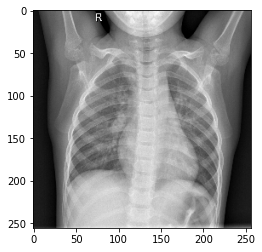

In [0]:
path = '/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
im = load_img(path, target_size=(256,256))
plt.imshow(im)

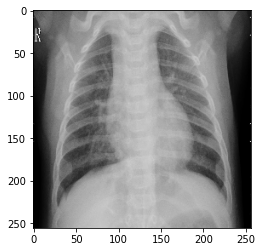

In [0]:
path = '/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'
im = load_img(path, target_size=(256,256))
plt.imshow(im)

Make a path to our files and load images.

In [0]:
train_normal = '/content/chest_xray/train/NORMAL'
train_pn = '/content/chest_xray/train/PNEUMONIA'

val_normal = '/content/chest_xray/val/NORMAL'
val_pn = '/content/chest_xray/val/PNEUMONIA'

test_normal = '/content/chest_xray/test/NORMAL'
test_pn = '/content/chest_xray/test/PNEUMONIA'

In [0]:
normal_train = glob.glob(train_normal+'/*.jpeg')
pneumonia_train = glob.glob(train_pn+'/*.jpeg')

normal_val = glob.glob(val_normal+'/*.jpeg')
pneumonia_val = glob.glob(val_pn+'/*.jpeg')

normal_test = glob.glob(test_normal+'/*.jpeg')
pneumonia_test = glob.glob(test_pn+'/*.jpeg')

You can check, but our validation data consists of only 16 images!! That's bad, that's why I will train our model on val and then on test set.

In [0]:
test = normal_test+pneumonia_test
np.random.shuffle(test)

train = normal_train+pneumonia_train
np.random.shuffle(train)

val = normal_val+pneumonia_val
np.random.shuffle(val)

Here's a function to preprocess our images where we'are using VGG16 preprocess function. We won't divide each array by standart deviation as VGG16 net only subtracts mean.

In [0]:
def preprocess(filenames):
    X = []
    y = []
    for image_filename in tqdm.tqdm(filenames):
      if 'NORMAL' in image_filename:
        label = 0
      else:
        label = 1
      img = load_img(image_filename, target_size=(256,256))
      img = img_to_array(img)
      X.append(img)
      y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return preprocess_input(X), to_categorical(y, 2)    

My RAM in google colab crashed while I was trying to train a model, so I saved vectors except TRAIN data, which you can find in the directory.

In [0]:
path = '/content/drive/My Drive/y_val.npz'
with np.load(path) as data:
  y_val = data['arr_0']
path = '/content/drive/My Drive/y_test.npz'
with np.load(path) as data:
  y_test = data['arr_0']

path = '/content/drive/My Drive/x_val.npz'
with np.load(path) as data:
  x_val = data['arr_0']
path = '/content/drive/My Drive/x_test.npz'
with np.load(path) as data:
  x_test = data['arr_0']

In [0]:
x_val.shape, x_test.shape, y_test.shape, y_val.shape # check that everything is okay

((16, 256, 256, 3), (624, 256, 256, 3), (624, 2), (16, 2))

In [0]:
x_train, y_train = preprocess(train) # and preprocess train data

100%|██████████| 5216/5216 [01:00<00:00, 86.11it/s]


In [0]:
x_val, y_val = preprocess(val) # if you load .npz files - don't do this

100%|██████████| 16/16 [00:00<00:00, 84.89it/s]


In [0]:
x_test, y_test = preprocess(test) # if you load .npz files - don't do this

100%|██████████| 624/624 [00:06<00:00, 100.93it/s]


In [0]:
x_train.shape, y_train.shape

((5216, 256, 256, 3), (5216, 2))

Now let's load our pretrained model.

In [0]:
base_model=VGG16(include_top=False, input_shape=(256,256,3))

I've tried using fine tuning but it doesn't help.

In [0]:
base_model.trainable = False

In [0]:
base_model.summary() # you can see that we have both trainable and untrainable params

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Build a model.

In [0]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [0]:
model.compile(optimizer=SGD(), metrics=['accuracy'], loss='binary_crossentropy')

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Define callbacks.

In [0]:
path = '/content/best_model_1.h5'
check = ModelCheckpoint(path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
reduce_lr=ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

1st fit is on val data, 2nd fit is on test data.

In [0]:
model.fit(x_train, y_train, epochs=7, batch_size=64, validation_data=(x_val, y_val),
                    callbacks=[check, reduce_lr]) # accuracy is 100%!!!

Epoch 1/7
82/82 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8823
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /content/best_model_1.h5
82/82 [==============================] - 18s 219ms/step - loss: 0.2911 - accuracy: 0.8823 - val_loss: 0.0748 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 2/7
82/82 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9584
Epoch 00002: val_accuracy did not improve from 1.00000
82/82 [==============================] - 16s 198ms/step - loss: 0.1142 - accuracy: 0.9584 - val_loss: 0.0860 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 3/7
82/82 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9711
Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
82/82 [==============================] - 16s 198ms/step - loss: 0.0828 - accuracy: 0.9711 - val_loss: 0.0602 - val_accuracy: 1.0000 - lr: 0.01

In [0]:
model.load_weights(path)

Let's see how good our model is by calculating precision, recall and plotting a confusion matrix.

In [0]:
preds = model.predict(x_test)
preds = np.argmax(preds, axis=-1)

In [0]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix

Transform out y_test to the representation of one column.

In [0]:
y_ts = []
for i in range(624):
  if y_test[i][0] == 0.:
    y_ts.append(1)
  else:
    y_ts.append(0)
y_ts = np.asarray(y_ts)

In [0]:
precision_score(y_ts, preds), recall_score(y_ts, preds)

(0.7748478701825557, 0.9794871794871794)

As you see we have really awesome **Recall** of 97.9% (by the way for our situation in trade-off between precision and recall we should choose higher recall as for us it's more important to find every patient with pneumonia (have less False negatives) rather than to miss him. So we should improve our model for **Precision** of 80% and higher.

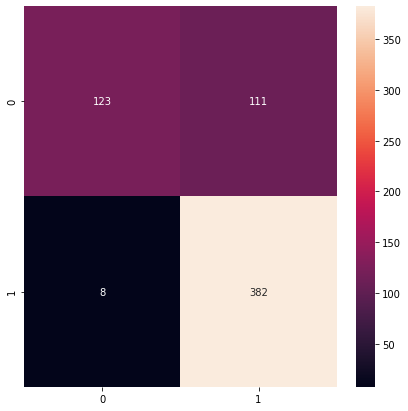

In [0]:
cm = confusion_matrix(y_ts,preds)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True, fmt='')

In [0]:
path = '/content/best_model_2.h5'
check = ModelCheckpoint(path, monitor='val_accuracy', save_best_only=True, verbose=1)
model.fit(x_train, y_train, epochs=7, batch_size=64, validation_data=(x_test, y_test),
                    callbacks=[check, reduce_lr]) # accuracy is 82%

Epoch 1/7
82/82 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9030
Epoch 00001: val_accuracy improved from -inf to 0.80609, saving model to /content/best_model_2.h5
82/82 [==============================] - 20s 249ms/step - loss: 0.2452 - accuracy: 0.9030 - val_loss: 0.6151 - val_accuracy: 0.8061 - lr: 0.0100
Epoch 2/7
82/82 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9615
Epoch 00002: val_accuracy did not improve from 0.80609
82/82 [==============================] - 18s 222ms/step - loss: 0.1072 - accuracy: 0.9615 - val_loss: 0.5993 - val_accuracy: 0.7869 - lr: 0.0100
Epoch 3/7
82/82 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9709
Epoch 00003: val_accuracy did not improve from 0.80609

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
82/82 [==============================] - 18s 221ms/step - loss: 0.0826 - accuracy: 0.9709 - val_loss: 0.5501 - val_accuracy: 0.7997 - lr: 0.01

In [0]:
model.load_weights(path)

In [0]:
preds = model.predict(x_val)
preds = np.argmax(preds, axis=-1)

In [0]:
y_vl = []
for i in range(16):
  if y_val[i][0] == 0.:
    y_vl.append(1)
  else:
    y_vl.append(0)
y_vl = np.asarray(y_vl)

If we choose test data as validation, then we have a **Recall** of 100% and **Precision** 0f 88% and that's much better! So we shouldn't use our initial validation set of size 16 as a true validation set, instead of this - use test set ou size 600+. To improve model you can choose more epochs and try different optimization functions.

In [0]:
precision_score(y_vl, preds), recall_score(y_vl, preds)

(0.8888888888888888, 1.0)

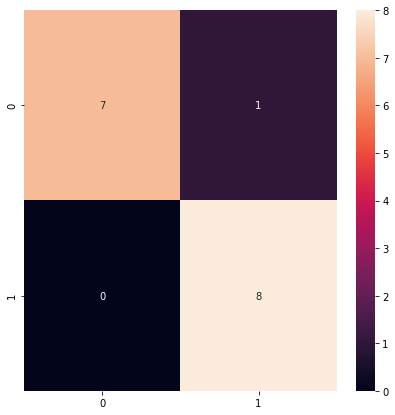

In [0]:
cm = confusion_matrix(y_vl,preds)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True, fmt='')

In [0]:
from google.colab import files

In [0]:
files.download('/content/best_model_1.h5')